# HR Analytics - Analyse des causes de démission

## Objectif
Identifier les causes racines du turnover élevé chez TechNova Partners et proposer des leviers d'action.

## 1. Chargement et Inspection des Données

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration de l'affichage
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")

In [45]:
# Chargement des fichiers
df_sirh = pd.read_csv('extrait_sirh.csv')
df_eval = pd.read_csv('extrait_eval.csv')
df_sondage = pd.read_csv('extrait_sondage.csv')

print("Dimensions SIRH:", df_sirh.shape)
print("Dimensions Eval:", df_eval.shape)
print("Dimensions Sondage:", df_sondage.shape)

Dimensions SIRH: (1470, 12)
Dimensions Eval: (1470, 10)
Dimensions Sondage: (1470, 12)


## 2. Nettoyage et Fusion des Données

Nous devons uniformiser les clés de jointure :
- `df_sirh` : `id_employee` est déjà un entier.
- `df_eval` : `eval_number` est sous la forme "E_XXX", nous devons extraire le nombre.
- `df_sondage` : `code_sondage` doit être converti en entier.

In [46]:
# Nettoyage des clés

# 1. SIRH : Renommer pour avoir une clé commune 'id'
df_sirh = df_sirh.rename(columns={'id_employee': 'id'})

# 2. Eval : Nettoyer 'eval_number' (ex: 'E_1' -> 1)
df_eval['id'] = df_eval['eval_number'].astype(str).str.replace('E_', '').astype(int)

# 3. Sondage : Renommer et s'assurer que c'est un int
df_sondage = df_sondage.rename(columns={'code_sondage': 'id'})
df_sondage['id'] = pd.to_numeric(df_sondage['id'], errors='coerce').astype('Int64')

# Vérification des doublons de clés
print("Doublons ID SIRH:", df_sirh['id'].duplicated().sum())
print("Doublons ID Eval:", df_eval['id'].duplicated().sum())
print("Doublons ID Sondage:", df_sondage['id'].duplicated().sum())

Doublons ID SIRH: 0
Doublons ID Eval: 0
Doublons ID Sondage: 0


In [47]:
# Fusion des dataframes
# On utilise un inner join pour ne garder que les employés présents dans les 3 bases
df_merged = df_sirh.merge(df_eval, on='id', how='inner')
df_merged = df_merged.merge(df_sondage, on='id', how='inner')

print("Dimensions après fusion:", df_merged.shape)
df_merged.head()

Dimensions après fusion: (1470, 33)


,id,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,eval_number,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,6,4,2,3,2,4,1,1,E_1,3,Oui,11 %,Oui,0,0,1,1,2,Infra & Cloud,Y,Occasionnel,0,5
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,10,7,3,2,2,2,4,3,E_2,4,Non,23 %,Non,1,3,1,8,1,Infra & Cloud,Y,Frequent,1,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,0,0,4,2,1,3,2,3,E_4,3,Oui,15 %,Oui,0,3,1,2,2,Autre,Y,Occasionnel,0,0
3,5,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,8,7,4,3,1,3,3,3,E_5,3,Oui,11 %,Non,0,3,1,3,4,Infra & Cloud,Y,Frequent,3,0
4,7,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,2,2,1,3,1,2,4,3,E_7,3,Non,12 %,Non,1,3,1,2,1,Transformation Digitale,Y,Occasionnel,2,2


In [48]:
# Vérification des valeurs manquantes après fusion
df_merged.isnull().sum()[df_merged.isnull().sum() > 0]

Series([], dtype: int64)

## 3. Analyse Exploratoire (EDA)
### 3.1 Analyse de la variable cible (Démission)

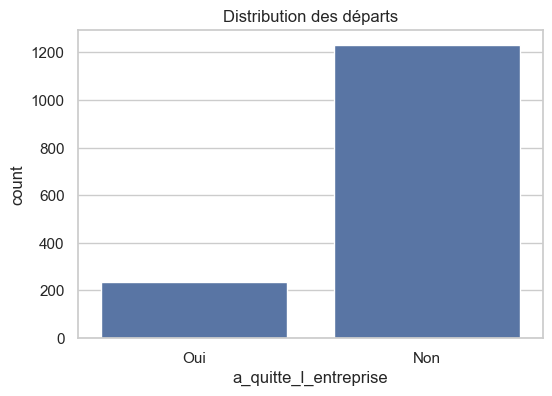

a_quitte_l_entreprise
Non    0.838776
Oui    0.161224
Name: proportion, dtype: float64


In [49]:
target_col = 'a_quitte_l_entreprise'

plt.figure(figsize=(6, 4))
sns.countplot(data=df_merged, x=target_col)
plt.title("Distribution des départs")
plt.show()

print(df_merged[target_col].value_counts(normalize=True))

### 3.2 Statistiques Descriptives

In [50]:
# Séparation des variables numériques et catégorielles
num_cols = df_merged.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_merged.select_dtypes(include=['object']).columns.tolist()

# Retirer 'id' des variables numériques
if 'id' in num_cols:
    num_cols.remove('id')

print("Variables numériques:", len(num_cols))
print("Variables catégorielles:", len(cat_cols))

# Statistiques descriptives pour les numériques
df_merged[num_cols].describe()

Variables numériques: 21
Variables catégorielles: 11


,age,revenu_mensuel,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,distance_domicile_travail,niveau_education,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
count,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,6502.931293,2.693197,80.0,11.279592,7.008163,4.229252,2.721769,2.729932,2.063946,2.728571,2.712245,2.761224,3.153741,0.793878,2.799320,1.0,9.192517,2.912925,2.187755,4.123129
std,9.135373,4707.956783,2.498009,0.0,7.780782,6.126525,3.623137,1.093082,0.711561,1.106940,1.102846,1.081209,0.706476,0.360824,0.852077,1.289271,0.0,8.106864,1.024165,3.222430,3.568136
min,18.000000,1009.000000,0.000000,80.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,0.000000,0.000000,1.0,1.000000,1.000000,0.000000,0.000000
25%,30.000000,2911.000000,1.000000,80.0,6.000000,3.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,3.000000,0.000000,2.000000,1.0,2.000000,2.000000,0.000000,2.000000
50%,36.000000,4919.000000,2.000000,80.0,10.000000,5.000000,3.000000,3.000000,3.000000,2.000000,3.000000,3.000000,3.000000,3.000000,1.000000,3.000000,1.0,7.000000,3.000000,1.000000,3.000000
75%,43.000000,8379.000000,4.000000,80.0,15.000000,9.000000,7.000000,4.000000,3.000000,3.000000,4.000000,4.000000,3.000000,3.000000,1.000000,3.000000,1.0,14.000000,4.000000,3.000000,7.000000
max,60.000000,19999.000000,9.000000,80.0,40.000000,40.000000,18.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,4.000000,3.000000,6.000000,1.0,29.000000,5.000000,15.000000,17.000000


### 3.3 Analyse des variables numériques vs Démission
Comparons les distributions des variables numériques pour ceux qui sont partis vs ceux qui sont restés.

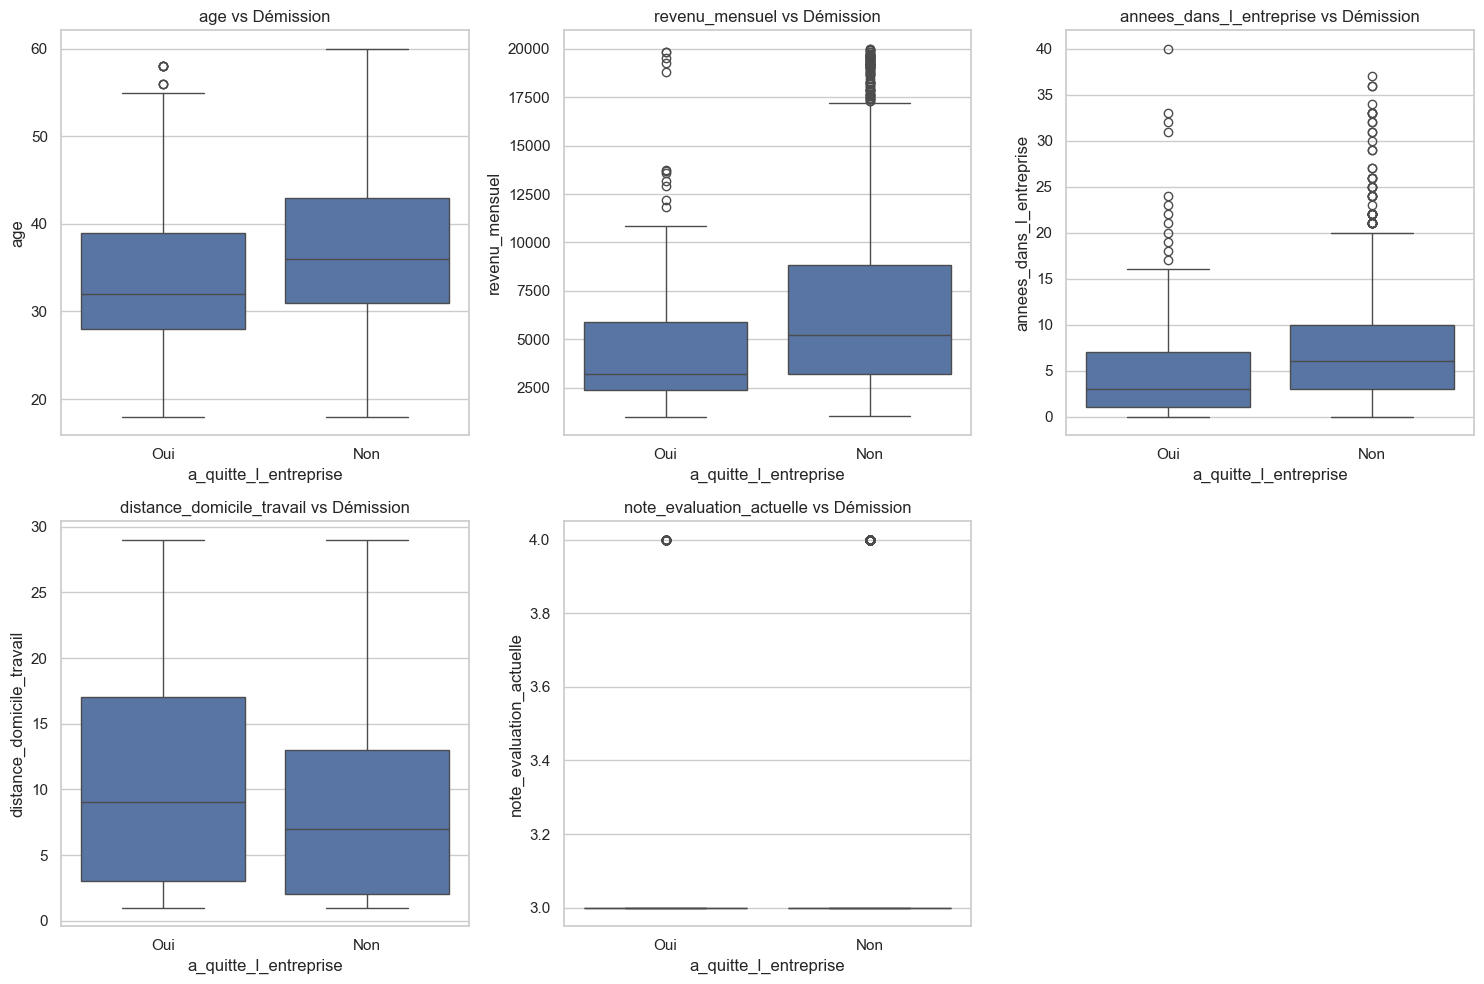

In [51]:
# Sélection de quelques variables clés pour l'analyse
key_num_cols = ['age', 'revenu_mensuel', 'annees_dans_l_entreprise', 'distance_domicile_travail', 'note_evaluation_actuelle']

plt.figure(figsize=(15, 10))
for i, col in enumerate(key_num_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df_merged, x=target_col, y=col)
    plt.title(f"{col} vs Démission")
plt.tight_layout()
plt.show()

### 3.4 Analyse des variables catégorielles vs Démission

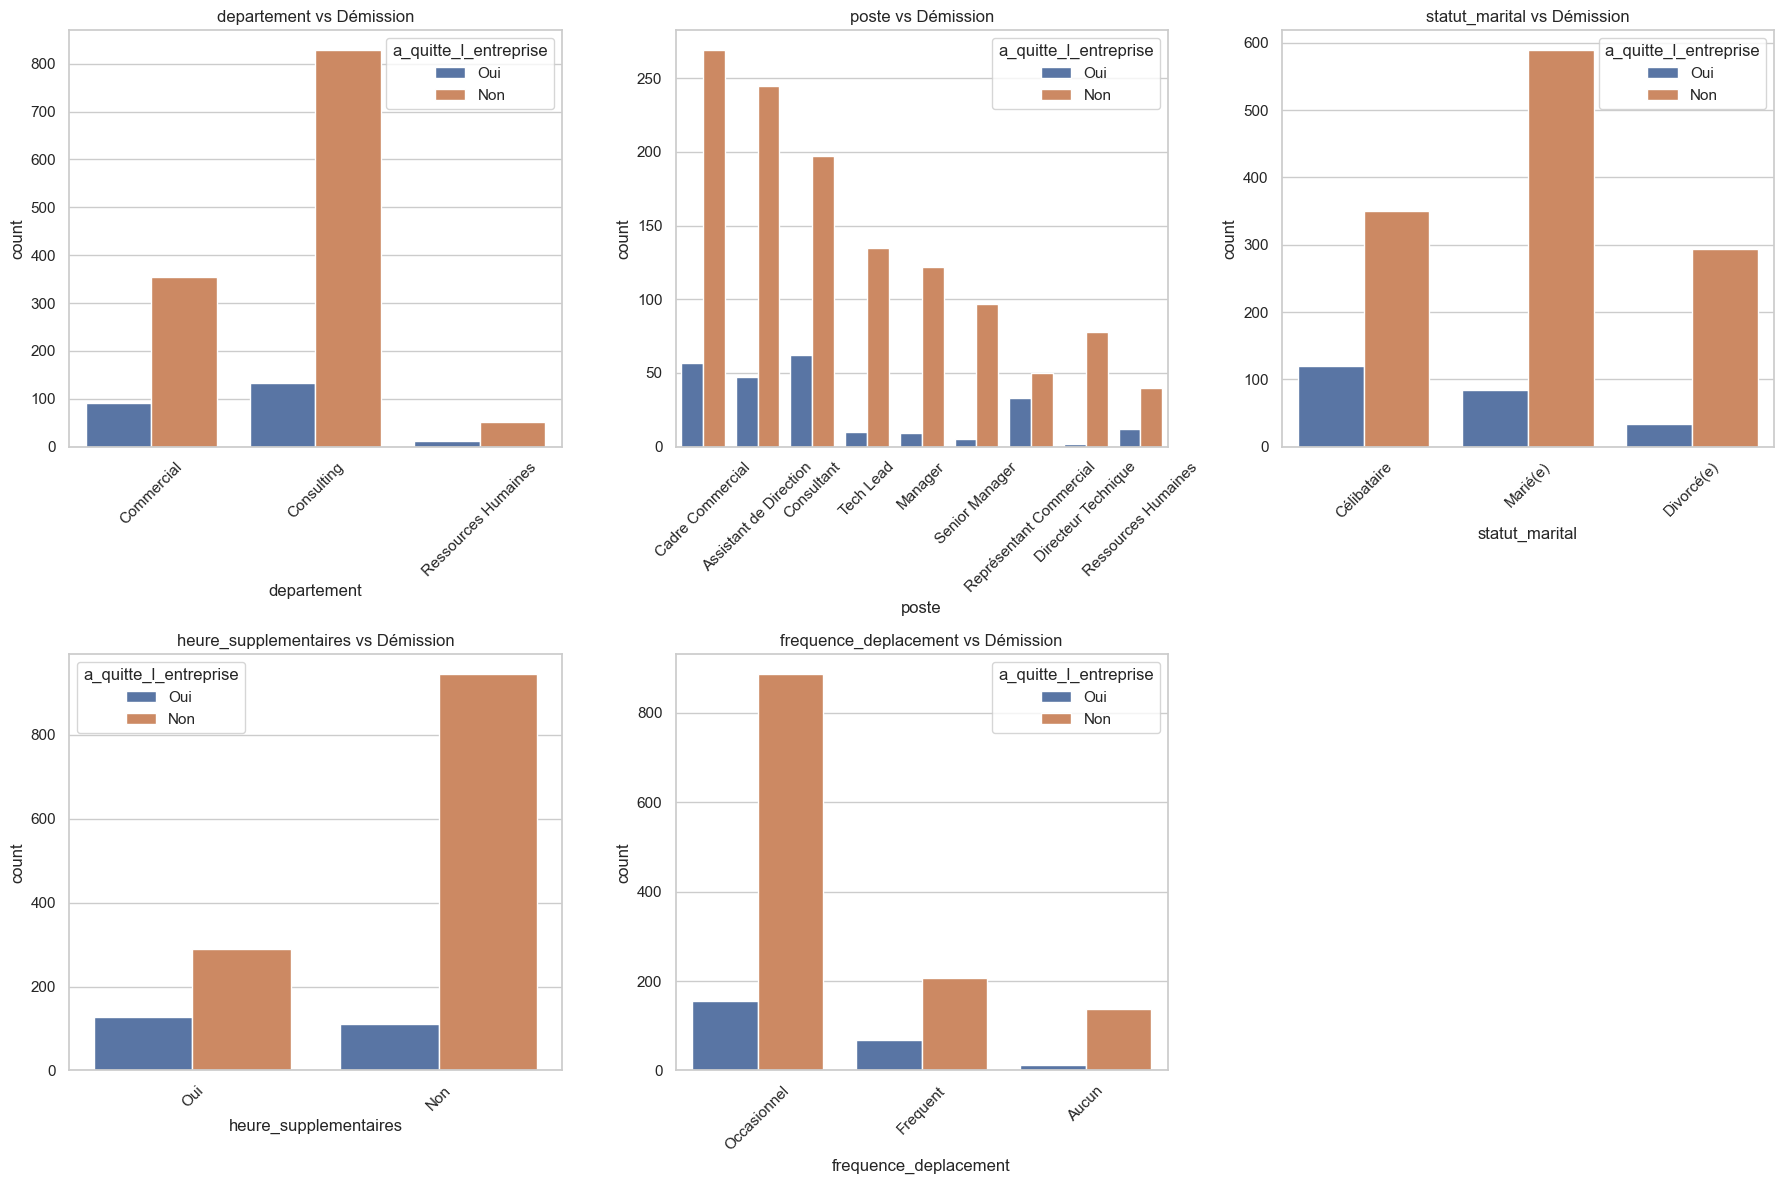

In [52]:
key_cat_cols = ['departement', 'poste', 'statut_marital', 'heure_supplementaires', 'frequence_deplacement']

plt.figure(figsize=(18, 12))
for i, col in enumerate(key_cat_cols, 1):
    plt.subplot(2, 3, i)
    sns.countplot(data=df_merged, x=col, hue=target_col)
    plt.title(f"{col} vs Démission")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3.5 Analyse de la Satisfaction

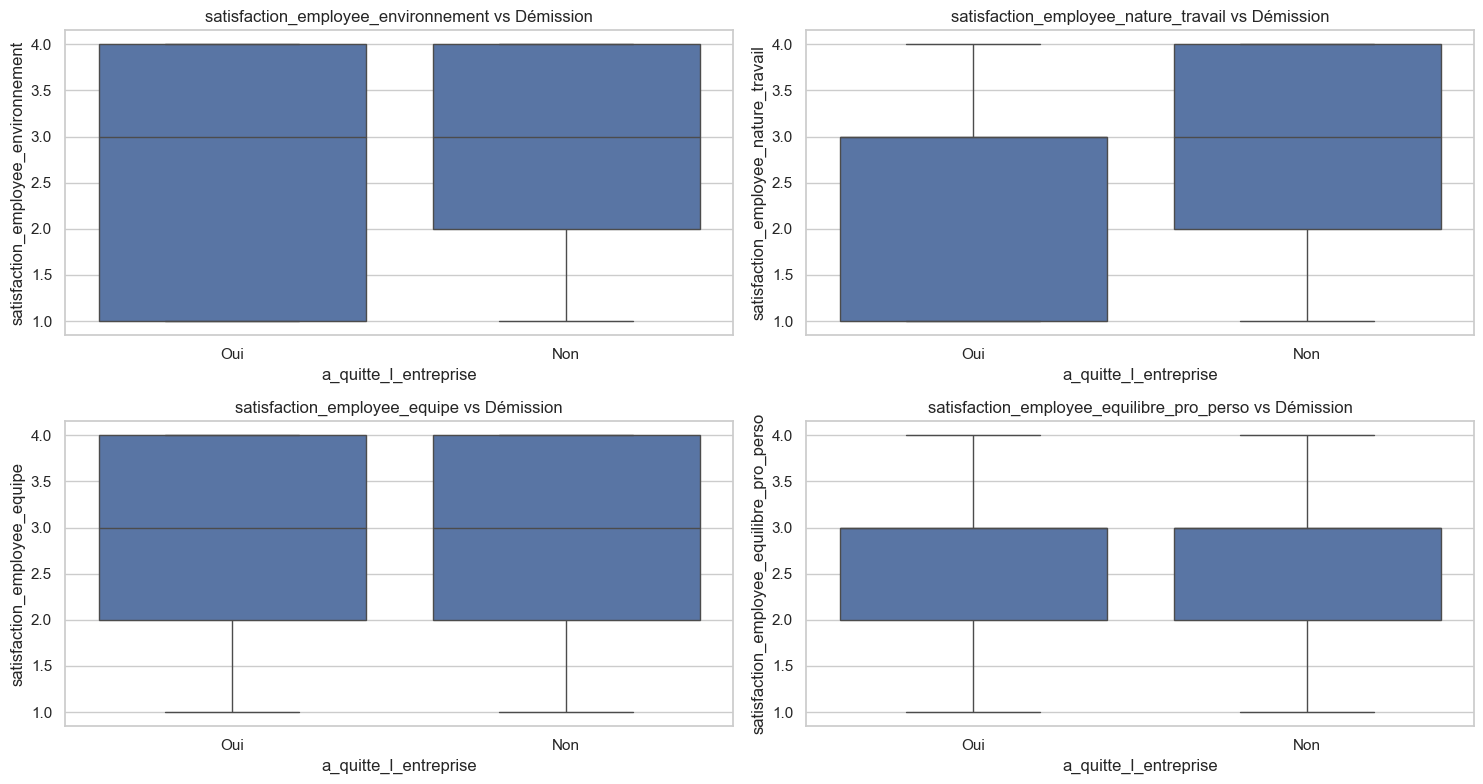

In [53]:
satisfaction_cols = [col for col in df_merged.columns if 'satisfaction' in col]

plt.figure(figsize=(15, 8))
for i, col in enumerate(satisfaction_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=df_merged, x=target_col, y=col)
    plt.title(f"{col} vs Démission")
plt.tight_layout()
plt.show()

## 4. Feature Engineering
### 4.1 Préparation de la variable cible

In [54]:
# Variable cible : conversion en binaire (Oui -> 1, Non -> 0)
df_merged['target'] = (df_merged['a_quitte_l_entreprise'] == 'Oui').astype(int)
print(df_merged['target'].value_counts())

target
0    1233
1     237
Name: count, dtype: int64


### 4.2 Identification des types de variables

In [55]:
# Colonnes à exclure
cols_to_exclude = ['id', 'a_quitte_l_entreprise', 'eval_number', 'target']

# Séparer les variables numériques et catégorielles
all_cols = [col for col in df_merged.columns if col not in cols_to_exclude]

# Variables numériques
num_cols = df_merged[all_cols].select_dtypes(include=[np.number]).columns.tolist()

# Variables catégorielles
cat_cols = df_merged[all_cols].select_dtypes(include=['object']).columns.tolist()

print(f"Variables numériques ({len(num_cols)}): {num_cols}")
print(f"\nVariables catégorielles ({len(cat_cols)}): {cat_cols}")

Variables numériques (21): ['age', 'revenu_mensuel', 'nombre_experiences_precedentes', 'nombre_heures_travailless', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'satisfaction_employee_environnement', 'note_evaluation_precedente', 'niveau_hierarchique_poste', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'note_evaluation_actuelle', 'nombre_participation_pee', 'nb_formations_suivies', 'nombre_employee_sous_responsabilite', 'distance_domicile_travail', 'niveau_education', 'annees_depuis_la_derniere_promotion', 'annes_sous_responsable_actuel']

Variables catégorielles (9): ['genre', 'statut_marital', 'departement', 'poste', 'heure_supplementaires', 'augementation_salaire_precedente', 'domaine_etude', 'ayant_enfants', 'frequence_deplacement']


### 4.2.b Suppression des variables constantes
Certaines variables peuvent avoir la même valeur pour tous les employés (variance nulle). Elles n'apportent aucune information au modèle et doivent être supprimées.

In [56]:
# Identification des variables constantes
const_cols = [col for col in df_merged.columns if df_merged[col].nunique() <= 1]
print(f"Variables constantes identifiées : {const_cols}")

# Suppression
if const_cols:
    df_merged = df_merged.drop(columns=const_cols)
    print("Variables supprimées.")
    
    # Mise à jour des listes de variables
    num_cols = [c for c in num_cols if c not in const_cols]
    cat_cols = [c for c in cat_cols if c not in const_cols]
    all_cols = [c for c in all_cols if c not in const_cols]
    print(f"Nouvelles dimensions : {df_merged.shape}")

Variables constantes identifiées : ['nombre_heures_travailless', 'nombre_employee_sous_responsabilite', 'ayant_enfants']
Variables supprimées.
Nouvelles dimensions : (1470, 31)


### 4.3 Analyse des corrélations (Pearson)
Pour les variables numériques uniquement

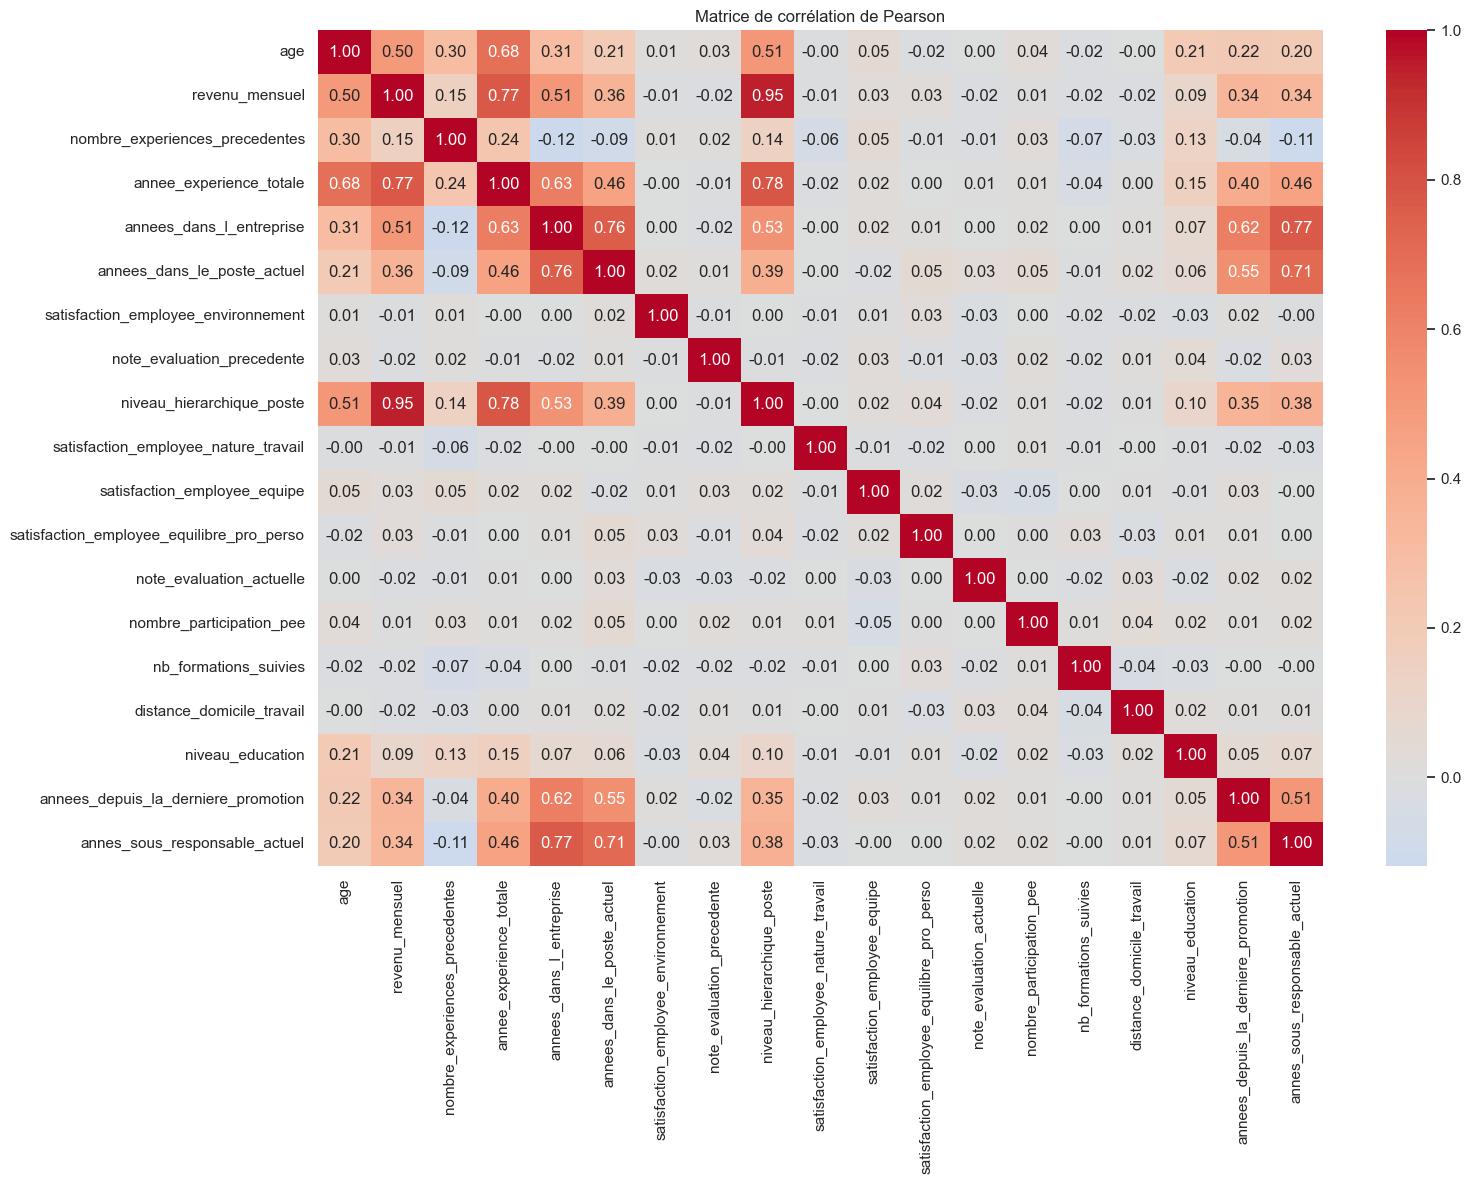


Paires de variables fortement corrélées (|r| > 0.8):
revenu_mensuel - niveau_hierarchique_poste: 0.950


In [57]:
# Matrice de corrélation de Pearson
corr_matrix = df_merged[num_cols].corr()

# Affichage heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Matrice de corrélation de Pearson')
plt.tight_layout()
plt.show()

# Variables fortement corrélées (|r| > 0.8)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

print("\nPaires de variables fortement corrélées (|r| > 0.8):")
for pair in high_corr_pairs:
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")

### 4.4 Encodage des variables catégorielles

In [58]:
# Création d'une copie pour le feature engineering
df_fe = df_merged.copy()

# Variables binaires à encoder avec LabelEncoder
binary_cols = [c for c in ['genre', 'heure_supplementaires'] if c in df_merged.columns]

# Variables catégorielles à encoder avec OneHotEncoder
onehot_cols = [col for col in cat_cols if col not in binary_cols]

print(f"Variables binaires: {binary_cols}")
print(f"Variables pour OneHot: {onehot_cols}")

Variables binaires: ['genre', 'heure_supplementaires']
Variables pour OneHot: ['statut_marital', 'departement', 'poste', 'augementation_salaire_precedente', 'domaine_etude', 'frequence_deplacement']


In [59]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder pour les variables binaires
le = LabelEncoder()
for col in binary_cols:
    df_fe[col + '_encoded'] = le.fit_transform(df_fe[col])
    print(f"{col}: {df_fe[col].unique()} -> {df_fe[col + '_encoded'].unique()}")

genre: ['F' 'M'] -> [0 1]
heure_supplementaires: ['Oui' 'Non'] -> [1 0]


In [60]:
# OneHotEncoder pour les autres variables catégorielles
df_fe = pd.get_dummies(df_fe, columns=onehot_cols, prefix=onehot_cols, drop_first=True, dtype=int)

print(f"\nNombre de colonnes après encodage: {df_fe.shape[1]}")
print(f"Nouvelles colonnes créées: {df_fe.shape[1] - df_merged.shape[1]}")


Nombre de colonnes après encodage: 60
Nouvelles colonnes créées: 29


### 4.5 Gestion des valeurs manquantes et colonnes à supprimer

In [61]:
# Vérifier les valeurs manquantes
missing = df_fe.isnull().sum()
if missing.sum() > 0:
    print("Valeurs manquantes:")
    print(missing[missing > 0])
else:
    print("Aucune valeur manquante")

Aucune valeur manquante


### 4.6 Création de X et y

In [62]:
# Colonnes à supprimer pour X
cols_to_drop = ['id', 'a_quitte_l_entreprise', 'eval_number'] + binary_cols + ['target']

# Créer X (features) et y (target)
X = df_fe.drop(columns=cols_to_drop, errors='ignore')
y = df_fe['target']

print(f"Dimensions de X: {X.shape}")
print(f"Dimensions de y: {y.shape}")
print(f"\nDistribution de y:")
print(y.value_counts(normalize=True))

Dimensions de X: (1470, 54)
Dimensions de y: (1470,)

Distribution de y:
target
0    0.838776
1    0.161224
Name: proportion, dtype: float64


### 4.7 Vérification finale

In [63]:
# Vérifier que X ne contient que des valeurs numériques
print("Types de données dans X:")
print(X.dtypes.value_counts())

# Afficher les premières lignes
print("\nPremières lignes de X:")
X.head()

Types de données dans X:
int64    54
Name: count, dtype: int64

Premières lignes de X:


,age,revenu_mensuel,nombre_experiences_precedentes,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle,nombre_participation_pee,nb_formations_suivies,distance_domicile_travail,niveau_education,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel,genre_encoded,heure_supplementaires_encoded,statut_marital_Divorcé(e),statut_marital_Marié(e),departement_Consulting,departement_Ressources Humaines,poste_Cadre Commercial,poste_Consultant,poste_Directeur Technique,poste_Manager,poste_Représentant Commercial,poste_Ressources Humaines,poste_Senior Manager,poste_Tech Lead,augementation_salaire_precedente_12 %,augementation_salaire_precedente_13 %,augementation_salaire_precedente_14 %,augementation_salaire_precedente_15 %,augementation_salaire_precedente_16 %,augementation_salaire_precedente_17 %,augementation_salaire_precedente_18 %,augementation_salaire_precedente_19 %,augementation_salaire_precedente_20 %,augementation_salaire_precedente_21 %,augementation_salaire_precedente_22 %,augementation_salaire_precedente_23 %,augementation_salaire_precedente_24 %,augementation_salaire_precedente_25 %,domaine_etude_Entrepreunariat,domaine_etude_Infra & Cloud,domaine_etude_Marketing,domaine_etude_Ressources Humaines,domaine_etude_Transformation Digitale,frequence_deplacement_Frequent,frequence_deplacement_Occasionnel
0,41,5993,8,8,6,4,2,3,2,4,1,1,3,0,0,1,2,0,5,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
1,49,5130,1,10,10,7,3,2,2,2,4,3,4,1,3,8,1,1,7,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
2,37,2090,6,7,0,0,4,2,1,3,2,3,3,0,3,2,2,0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,33,2909,1,8,8,7,4,3,1,3,3,3,3,0,3,3,4,3,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,27,3468,9,6,2,2,1,3,1,2,4,3,3,1,3,2,1,2,2,1,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


In [64]:
# Sauvegarder X et y pour utilisation ultérieure
print("Dimensions finales:")
print(f"- X: {X.shape[0]} lignes, {X.shape[1]} features")
print(f"- y: {y.shape[0]} lignes")
print(f"\nTaux de démission: {y.mean():.2%}")

Dimensions finales:
- X: 1470 lignes, 54 features
- y: 1470 lignes

Taux de démission: 16.12%
